In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive")

In [12]:
%cd /content/drive/Shareddrives

/content/drive/Shareddrives


In [14]:
!ls

In [15]:
cd /content/drive/MyDrive/COSMIC/erc-training

/content/drive/.shortcut-targets-by-id/1-3THX-pVEawAfZ6tnf9PtnCAXWOUksLv/COSMIC/erc-training


In [77]:
from dataloader import IEMOCAPRobertaCometDataset

trainset = IEMOCAPRobertaCometDataset('train')
validset = IEMOCAPRobertaCometDataset('valid')
testset = IEMOCAPRobertaCometDataset('test')

train_loader = DataLoader(trainset,
                          batch_size=32,
                          collate_fn=trainset.collate_fn,
                          num_workers=0,
                          )

valid_loader = DataLoader(validset,
                          batch_size=32,
                          collate_fn=trainset.collate_fn,
                          num_workers=0,
                          )

test_loader = DataLoader(testset,
                          batch_size=1,
                          collate_fn=testset.collate_fn,
                          num_workers=0,
                          )
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))
# num_samples_to_display = 5

# for i in range(num_samples_to_display):
#     sample = trainset[i]
#     print(f"Sample {i}: {sample}")
#     print("-----------------------------------------------------")

4
1
31


In [78]:

for data in test_loader:

    inputs, labels, vids = data[0], data[-2], data[-1]
    print(vids)
    print(labels)
    print(len(labels),len(vids))
    for i in range(len(labels)):
      for j in range(len(testset.sentences[vids[i]])):

        print(labels[i][j])
        print(testset.sentences[vids[i]][j])
      # print(labels[i])
      # print(len(labels[i]), len(testset.sentences[vids[i]]))
      break



['Ses05M_impro03']
tensor([[4, 2, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 4, 4, 0, 0, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0,
         0, 2, 4, 2, 0, 0, 2, 0, 0, 0]])
1 1
tensor(4)
Guess what?
tensor(2)
what?
tensor(4)
I did it, I asked her to marry me.
tensor(4)
Yes, I did it.
tensor(4)
When?
tensor(4)
Oh my god, it was just last weekend.
tensor(4)
Oh, what, how- where how did you do it?
tensor(0)
She--,well, she said yes, first of all, let me say that right off the bat. Well, I would like to assume, too.  But you never know these things, right?
tensor(4)
Okay good. I I assumed.
tensor(0)
oh-
tensor(0)
I did it up at Yosemite.  We went camping right like we usually do.  You know we go camping up there all the time.  But, um- the waterfalls had died down a little bit, you know. And so uh- we-I had her climb up.
tensor(0)
You know- we did some- you know some rock climbing up the waterfalls and went up to this little pool that was up

In [79]:
%pwd

'/content/drive/.shortcut-targets-by-id/1-3THX-pVEawAfZ6tnf9PtnCAXWOUksLv/COSMIC/erc-training'

In [108]:
from torch.nn.modules import dropout
D_m = 1024
D_s = 768
D_g = 150
D_p = 150
D_r = 150
D_i = 150
D_h = 100
D_a = 100

D_e = D_p + D_r + D_i
n_classes = 6
emo_gru = True
active_listener = True
attention = "general2"
rec_dropout = 0.1
dropout = 0.25
mode1 = 2
norm = 3
residual = False
model = CommonsenseGRUModel(D_m, D_s, D_g, D_p, D_r, D_i, D_e, D_h, D_a,
                            n_classes=n_classes,
                            listener_state=active_listener,
                            context_attention=attention,
                            dropout_rec=rec_dropout,
                            dropout=dropout,
                            emo_gru=emo_gru,
                            mode1=mode1,
                            norm=norm,
                            residual=residual)
print('IEMOCAP COSMIC Model.')
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()

best_model_path = "best_model_5.pt"
model.load_state_dict(torch.load(best_model_path))

model.eval()

error_data = []
all_data = []
for data in test_loader:

  r1, r2, r3, r4, \
      x1, x2, x3, x4, x5, x6, \
      o1, o2, o3, \
      qmask, umask, label = [d.cuda() for d in data[:-1]] if cuda else data[:-1]
  vids = data[-1]
  with torch.no_grad():
    log_prob, _, alpha, alpha_f, alpha_b, _ = model(r1, r2, r3, r4, x5, x6, x1, o2, o3, qmask, umask, att2=True)

    lp_ = log_prob.transpose(0, 1).contiguous().view(-1, log_prob.size()[2])  # batch*seq_len, n_classes
    labels_ = label.view(-1)  # batch*seq_len

  pred_ = torch.argmax(lp_, 1)  # batch*seq_len
  preds= pred_.data.cpu().numpy()
  labels = labels_.data.cpu().numpy()

  for i in range(len(preds)):
    gt_label = labels[i].item()
    pred_label = preds[i].item()
    all_data.append((gt_label, pred_label))
    if gt_label != pred_label:
      sentence = test_loader.dataset.sentences[vids[0]][i]

      error_data.append((sentence, gt_label, pred_label))



IEMOCAP COSMIC Model.


In [109]:
import pandas as pd
error_df = pd.DataFrame(error_data, columns=['Sentence', 'Ground Truth Label', 'Predicted Label'])
all_data_df = pd.DataFrame(all_data, columns=['Ground Truth Label', 'Predicted Label'])

F1 score for different label

In [110]:
from sklearn.metrics import f1_score

y_true = all_data_df['Ground Truth Label']
y_pred = all_data_df['Predicted Label']

f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5])

labels = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
label_f1_scores = dict(zip(labels, f1_scores))

for k,v in label_f1_scores.items():
  print(f"The F1 score of label {k} is {v}")



The F1 score of label hap is 0.4738461538461538
The F1 score of label sad is 0.7924528301886794
The F1 score of label neu is 0.6231527093596059
The F1 score of label ang is 0.5328467153284672
The F1 score of label exc is 0.6287878787878788
The F1 score of label fru is 0.6602409638554217


In [112]:
print(f"prediction accuracy is {(len(all_data) - len(error_data))/len(all_data)}")

prediction accuracy is 0.6358595194085028


distribution of error predictions

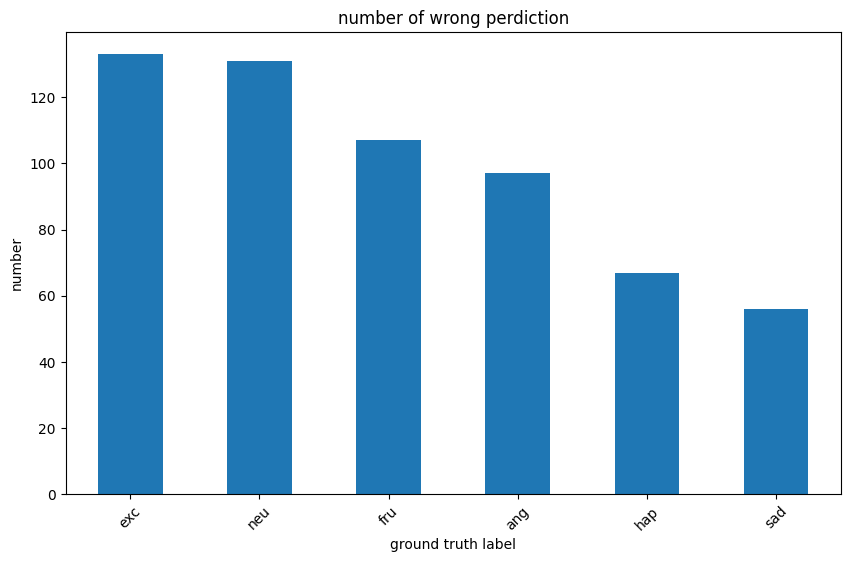

In [114]:
import matplotlib.pyplot as plt

label_mapping = {'hap': 0, 'sad': 1, 'neu': 2, 'ang': 3, 'exc': 4, 'fru': 5}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

error_df['Ground Truth Label'] = error_df['Ground Truth Label'].map(inverse_label_mapping)
error_df['Predicted Label'] = error_df['Predicted Label'].map(inverse_label_mapping)

error_count_by_gt_label = error_df['Ground Truth Label'].value_counts()

plt.figure(figsize=(10, 6))
error_count_by_gt_label.plot(kind='bar')
plt.title('number of wrong perdiction')
plt.xlabel('ground truth label')
plt.ylabel('number')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

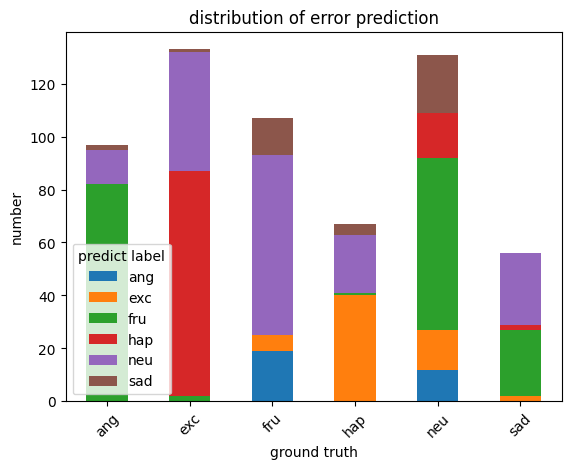

In [115]:
error_distribution_by_gt_label = error_df.groupby('Ground Truth Label')['Predicted Label'].value_counts().unstack()

plt.figure(figsize=(12, 8))
error_distribution_by_gt_label.plot(kind='bar', stacked=True)
plt.title('distribution of error prediction')
plt.xlabel('ground truth')
plt.ylabel('number')
plt.xticks(rotation=45)
plt.legend(title='predict label')
plt.show()

error prediction samples

In [119]:
for label in error_df['Ground Truth Label'].unique():
    print(f"\nError prediction samples of {label}:")
    sample_data = error_df[error_df['Ground Truth Label'] == label].sample(5)

    for _, row in sample_data.iterrows():
        sentence = row['Sentence']
        predicted_label = row['Predicted Label']
        print(f"'{sentence}'，\tpredict label: '{predicted_label}'")




Error prediction samples of neu:
'Right, but this is the wrong form.  Somebody gave you the wrong form.'，	predict label: 'fru'
'Well, as I told you, it left Heath Row and it seems to have arrived here.  But if you can't find it, then-are you sure you know what your bag looks like?'，	predict label: 'fru'
'Well, what if-what happens when our love-'，	predict label: 'hap'
'How did you know?'，	predict label: 'hap'
'Hi, I need an ID.'，	predict label: 'fru'

Error prediction samples of exc:
'oh yeah.'，	predict label: 'hap'
'Oh my god, it was just last weekend.'，	predict label: 'hap'
'Good.  We'll have to have one soon, you're going to have to go to school in a couple of months.'，	predict label: 'hap'
'You feel it's wrong here, don't you- this yard, this chair?  I want you to be ready for me Annie.  I don't want to win you away from anything.'，	predict label: 'hap'
'Yeah.  Yeah, of course.'，	predict label: 'hap'

Error prediction samples of hap:
'There's actually, a friend of mine is um- movi